In [3]:
import torch
import torchvision
from PIL import Image
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [4]:
# Load a pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Set the model to evaluation mode
model.eval()


c:\Users\nickj\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\nickj\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [5]:
# Show all model layers
for name, param in model.named_parameters():
    print(name, param.size())

backbone.body.conv1.weight torch.Size([64, 3, 7, 7])
backbone.body.layer1.0.conv1.weight torch.Size([64, 64, 1, 1])
backbone.body.layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
backbone.body.layer1.0.conv3.weight torch.Size([256, 64, 1, 1])
backbone.body.layer1.0.downsample.0.weight torch.Size([256, 64, 1, 1])
backbone.body.layer1.1.conv1.weight torch.Size([64, 256, 1, 1])
backbone.body.layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
backbone.body.layer1.1.conv3.weight torch.Size([256, 64, 1, 1])
backbone.body.layer1.2.conv1.weight torch.Size([64, 256, 1, 1])
backbone.body.layer1.2.conv2.weight torch.Size([64, 64, 3, 3])
backbone.body.layer1.2.conv3.weight torch.Size([256, 64, 1, 1])
backbone.body.layer2.0.conv1.weight torch.Size([128, 256, 1, 1])
backbone.body.layer2.0.conv2.weight torch.Size([128, 128, 3, 3])
backbone.body.layer2.0.conv3.weight torch.Size([512, 128, 1, 1])
backbone.body.layer2.0.downsample.0.weight torch.Size([512, 256, 1, 1])
backbone.body.layer2.1.conv1.weight t

In [6]:
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# num_classes = 5
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [7]:
def display_bounding_boxes(input_image, model_outputs, thresh = 0.8):

    boxes = model_outputs[0]['boxes']
    cleaned_boxes = []
    for box in boxes:
        box = box.detach().numpy()
        box = box.astype(int)
        cleaned_boxes.append(box)

    scores = model_outputs[0]['scores']
    for i in range(len(scores)):
        if scores[i] < thresh:
            cleaned_boxes[i] = None
            
    cleaned_boxes = [box for box in cleaned_boxes if box is not None]

    # Create figure and axes
    fig, ax = plt.subplots()
    # Display the image
    ax.imshow(input_image[0].permute(1, 2, 0))

    # Create a Rectangle patch for each cleaned box and add to the plot
    for box in cleaned_boxes:
        rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()
    

In [8]:
# Pass test_image.jpg thrpugh the model
image_path = '../data/test_image.jpg'
image = Image.open(image_path)
print(type(image))
# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(), # Converts the image to a PyTorch tensor
    # Normalize the image to the same mean and std used during training
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
tensor_transform = transforms.ToTensor()

# Apply the transformation to your image
normalized_image = transform(image).unsqueeze(0)

outputs = model(normalized_image)

# Print the model outputs

print(outputs)

<class 'PIL.JpegImagePlugin.JpegImageFile'>
[{'boxes': tensor([[ 707.1644,   23.7286,  877.8981,  226.7212],
        [ 284.2302,   50.6857,  403.0121,  125.8201],
        [ 569.6964,  250.5988,  645.5336,  329.9851],
        [ 560.4731,  671.5861,  607.9172,  716.9049],
        [ 229.3491,  170.1511,  279.1775,  287.0392],
        [ 179.6350,  114.8024,  228.1195,  163.0325],
        [ 565.3688,  217.4895,  691.4082,  321.9857],
        [ 532.7118,  208.0915,  643.9644,  276.0956],
        [1135.4473,  173.7498, 1263.5020,  267.0495],
        [1032.5662,   65.8277, 1081.9634,  116.3930],
        [ 515.6432,  205.2241, 1247.1160,  697.1872]],
       grad_fn=<StackBackward0>), 'labels': tensor([ 1,  3,  3,  3,  1,  3,  3,  3,  3, 85,  3]), 'scores': tensor([0.9387, 0.2564, 0.1519, 0.1202, 0.1176, 0.0909, 0.0764, 0.0715, 0.0645,
        0.0595, 0.0556], grad_fn=<IndexBackward0>)}]


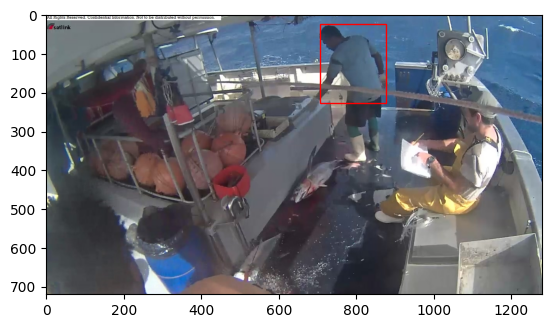

In [9]:
display_bounding_boxes(tensor_transform(image).unsqueeze(0), outputs, thresh=0.8)
